In [1]:
# This is a notebook for evaluating and plotting the results of Task 2 experiments. 
# To run an experiment, use:
# Task2_Chemists_component.ipynb and
# run Reinvent 3.2 with config_tX.json and config_tX_sampling.json for X=0,...,T in the result folder (use runs.sh and run_sampling.sh in a computation cluster)

import os
import pickle
import numpy as np
import pandas as pd
import fnmatch
import reinvent_scoring
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline


jobname = ['Task2_demo_thompson']
result_dir ='./results/'
save_result_dir = './'

acquisitions = ['random', 'greedy', 'thompson', 'uncertainty']
# options for plotting
method_colors = {'uncertainty': 'C1',
                 'random': 'C2',
                'greedy': 'C3',
                'thompson': 'C0'}
method_names = {'uncertainty': 'Uncertainty sampling',
                 'random': 'Random sampling',
                'greedy': 'Pure exploitation',
               'thompson': 'Thompson sampling'} 

RDKit WARNING: [19:11:43] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
# Oracle model:
expert_model_path = './data/drd2.pkl'
qsar_model = {
    "component_type": "predictive_property",
    "name": "DRD2",
    "weight": 1,
    "specific_parameters": {
        "model_path": expert_model_path,
        "scikit": "classification",
        "descriptor_type": "ecfp",
        "size": 2048,
        "radius": 3,
        "use_counts": True,
        "use_features": True,
        "transformation": {
            "transformation_type": "no_transformation"
      }
    }
  }

scoring_function = {
  "name": "custom_sum",
  "parallel": False,
  "parameters": [
    qsar_model
  ]
}
scoring_function_parameters = reinvent_scoring.scoring.ScoringFunctionParameters(**scoring_function)
expert_scoring_function = reinvent_scoring.scoring.ScoringFunctionFactory(scoring_function_parameters)

In [3]:
def score_sampled_smiles(file):
    data = pd.read_csv(file).to_numpy()
    data =np.squeeze(data)
    summary = expert_scoring_function.get_final_score(data)
    return summary.total_score

In [4]:
result_dir_per_job={}
print('reading {}'.format(result_dir))
for fname in os.listdir(result_dir):
    for job in jobname:
        if fnmatch.fnmatch(fname,job+'*'):
            #take care the position of acquisition method in file name
            print(job)
            acquisition=job.split('_')[2]
            if acquisition in result_dir_per_job.keys():
                result_dir_per_job[acquisition].append(result_dir+fname+'/loop0/')
            else:
                result_dir_per_job[acquisition]=[result_dir+fname+'/loop0/']

for key in result_dir_per_job.keys():
    assert key in acquisitions, "take care the position of acquisition method in file name"

reading ./results/
Task2_demo_thompson


In [5]:
def parallel_processing(params):
    res={}
    key,folders=params[0],params[1]
    acquisition=key
    res[acquisition]={}
    for folder in folders:
        print("processing " +folder)
        files=os.listdir(folder)
        for filename in files:
            if filename.endswith(".p"):
                dat_save = pickle.load(open(folder + filename, "rb" ))
                # collect results
                for key, value in dat_save.items():
                    if key in res[acquisition]:
                        #assume experiment should have the same 'hitl params'
                        if 'baseline' in key:
                            res[acquisition][key]=np.append(res[acquisition][key],value)
                        elif key!='idx_query' and key!='hitl params':
                            res[acquisition][key]=np.vstack((res[acquisition][key],value))
                    else:
                        if key=='hitl params':
                            for k, v in value.items():
                                res[acquisition][k]=v
                        elif 'baseline' in key:
                            res[acquisition][key]=np.array([value])
                        elif key!='idx_query':
                            res[acquisition][key] = np.array(value)
                            res[acquisition]['Expert score REINVENT output'] = []
        sc=[]
        for it in np.arange(0,res[acquisition]['T']+1,res[acquisition]['step']):
            sampled_smiles = folder + 'results_t{}/sampled.csv'.format(it)
            print('processing ' + sampled_smiles)
            try:
                sc += [score_sampled_smiles(sampled_smiles)]
            except FileNotFoundError:
                print("MISSING RESULT {}, please sample molecules from your agent".format(sampled_smiles))  
                sc += [np.nan]
        res[acquisition]['Expert score REINVENT output'] += [sc]

    return res

In [6]:
params=[[key, folders] for key, folders in result_dir_per_job.items() ]
with Pool(len(jobname)) as p:
    mapped_pool=p.map(parallel_processing,params)
res={}
for i in range(len(mapped_pool)):
    res.update(mapped_pool[i])

processing ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/
processing ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t0/sampled.csv
MISSING RESULT ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t0/sampled.csv, please sample molecules from your agent
processing ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t1/sampled.csv
MISSING RESULT ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t1/sampled.csv, please sample molecules from your agent
processing ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t2/sampled.csv
MISSING RESULT ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t2/sampled.csv, please sample molecules from your agent
processing ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t3/sampled.csv
MISSING RESULT ./results/Task2_demo_thompson_25-02-2024_seed_1718/loop0/results_t3/sampled.csv, please sample molecules from your agent
processing ./results/Ta

In [7]:
def shadedplot(x, y, fill=True, label='', color=''):
    p = plt.plot(x, y[0,:], label=label, color=color)
    c = p[-1].get_color()
    if fill:
        plt.fill_between(x, y[1,:], y[2,:], color=c, alpha=0.25)

thompson


/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/home/springnuance/miniconda3/envs/cc_env_hitl/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(0.0, 1.0)

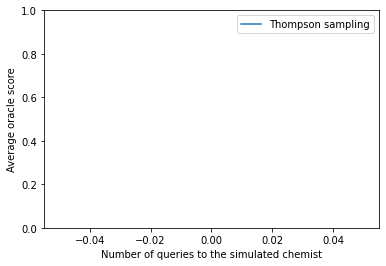

In [8]:
# Plot Expert score in REINVENT output
for acquisition in res.keys():
    print(acquisition)
    if acquisition not in acquisitions:
        continue
    rs = res[acquisition]['Expert score REINVENT output']
    r = np.array([[np.nanmean(scores) for scores in rs[i]] for i in np.arange(len(rs))])
    m = np.nanmean(r, axis=0)
    sd = np.nanstd(r, axis=0)/np.sqrt(r.shape[0]) #SEM
    x = np.arange(len(m))
    N0=res[acquisition]['N0']
    x[0] = N0
    step=res[acquisition]['step']
    n_batch=res[acquisition]['n_batch']
    for i in np.arange(1,len(x)):
        x[i]=x[i-1]+n_batch*step
    if(r.shape[0]>1): # If multiple repetitions
        shadedplot(x, np.array([m, m-sd,m+sd]), fill=True,label=method_names[acquisition], color=method_colors[acquisition])
    for line in np.arange(r.shape[0]):
        p = np.isnan(r[line,:]) # remove missing iterations
        p = [not b for b in p]
        plt.plot(x[p], r[line,p], color=method_colors[acquisition], label=method_names[acquisition])

plt.legend()
plt.xlabel('Number of queries to the simulated chemist')
plt.ylabel('Average oracle score')
plt.ylim([0,1])
#plt.savefig(save_result_dir + "{}_Expert_score_REINVENT_output.png".format(jobname[0]),bbox_inches='tight')